In [1]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pyro.nn import PyroModule, PyroSample
from torch import nn
import torch
import pyro.distributions as dist
from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import functools
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator, one_step_corrected_estimator 
from typing import Callable
from tqdm import tqdm

torch.set_default_device('cpu')

smoke_test = "CI" in os.environ

In [66]:
class BayesianLinearGaussianSCM(PyroModule):
    def __init__(self):
        super().__init__()

    @PyroSample
    def alpha(self):
        return dist.Normal(0,10)

    @PyroSample
    def beta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def gamma(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def delta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def sigmaZ(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaH(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaX(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaY(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def meanH(self):
        return dist.Normal(0,0.001)
    
    def forward(self):
        Z = pyro.sample('Z',dist.Normal(0,self.sigmaZ))
        H = pyro.sample('H',dist.Normal(self.meanH, self.sigmaH))
        X = pyro.sample('X',dist.Normal(self.beta * Z + self.gamma * H, self.sigmaX))
        Y = pyro.sample('Y',dist.Normal(self.alpha * X + self.delta * H, self.sigmaY))
        return X,Y,Z
    
class GroundTruthModel(BayesianLinearGaussianSCM):
    def __init__(self, alpha, beta, gamma, delta, sigmaZ, sigmaH, sigmaX, sigmaY, meanH):
        super().__init__()
        self._alpha = alpha
        self._beta = beta
        self._gamma = gamma
        self._delta = delta
        self._sigmaZ = sigmaZ
        self._sigmaH = sigmaH
        self._sigmaX = sigmaX
        self._sigmaY = sigmaY
        self._meanH = meanH


    @property
    def alpha(self):
        return self._alpha
    
    @property
    def beta(self):
        return self._beta
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def delta(self):
        return self._delta
    
    @property
    def sigmaZ(self):
        return self._sigmaZ
    
    @property
    def sigmaH(self):
        return self._sigmaH
    
    @property
    def sigmaX(self):
        return self._sigmaX
    
    @property
    def sigmaY(self):
        return self._sigmaY
    
    @property
    def meanH(self):
        return self._meanH
    

true_alpha, true_beta, true_gamma, true_delta = torch.tensor(1.5), torch.tensor(2.0), torch.tensor(2.0), torch.tensor(-1.7)
true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY = torch.tensor(0.1), torch.tensor(0.1), torch.tensor(0.1), torch.tensor(0.1)
true_meanH = torch.tensor(0.0)

num_samples = 100000

gt_model = GroundTruthModel(true_alpha, true_beta, true_gamma, true_delta, true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY, true_meanH)

# sample from the model
with pyro.plate('samples', num_samples):
    tr=pyro.poutine.trace(gt_model).get_trace()

x_obs,y_obs,z_obs=[tr.nodes[name]['value'] for name in ['X','Y','Z']]


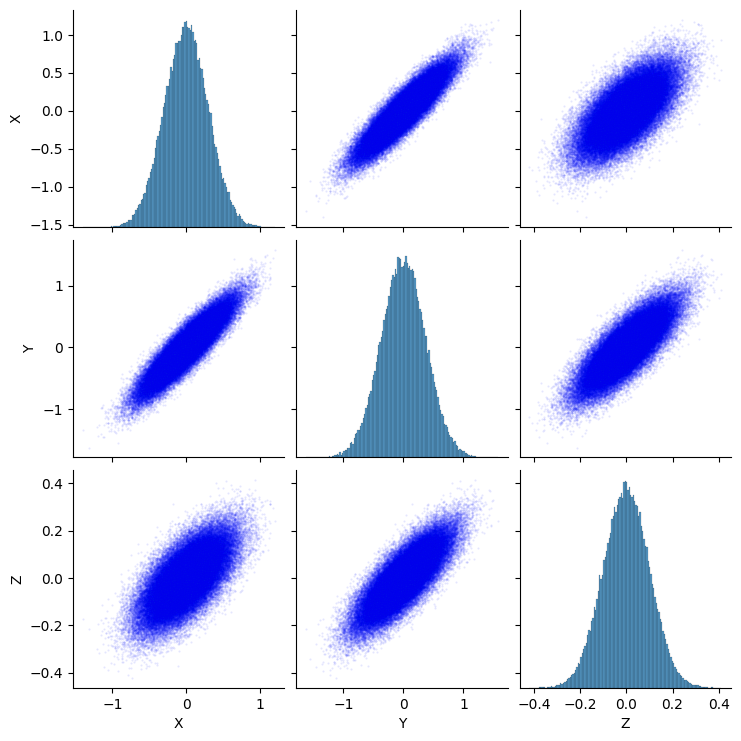

In [67]:
sns.pairplot(pd.DataFrame({'X':x_obs,'Y':y_obs,'Z':z_obs}), kind='scatter', markers='.', plot_kws=dict(s=1, edgecolor='b', alpha=0.1, linewidth=1))
plt.show()

Attempt to infer the posterior of the parameters

In [68]:
class ObservedBayesianLinearGaussianSCM(BayesianLinearGaussianSCM):
    def __init__(self):
        super().__init__()

    def forward(self, X : torch.tensor, Y: torch.tensor,Z : torch.tensor):
        self.alpha, self.beta, self.gamma, self.delta, self.sigmaZ, self.sigmaH, self.sigmaX, self.sigmaY, self.meanH
        with condition(data={'Z': Z, 'X' : X, 'Y': Y}):
            with pyro.plate("data", Z.shape[0], dim=-1):
                return super().forward()

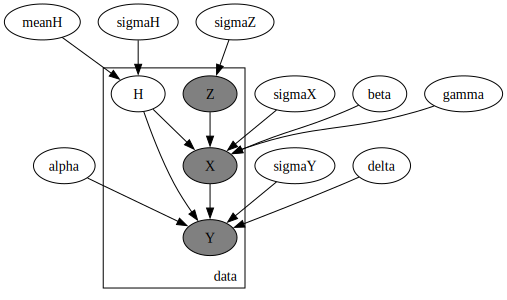

In [69]:
pyro.render_model(ObservedBayesianLinearGaussianSCM(),(x_obs,y_obs,z_obs))

loss=Inf:   0%|          | 0/5000 [00:00<?, ?it/s]

loss=-147394.296875: 100%|██████████| 5000/5000 [01:32<00:00, 54.03it/s] 


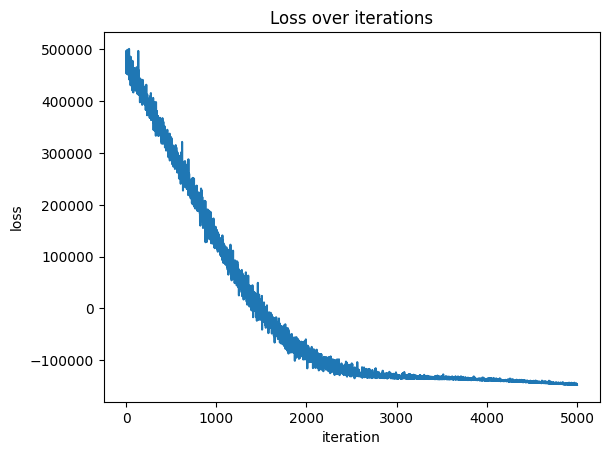

In [70]:
num_iterations = 5000 if not smoke_test else 10

pyro.clear_param_store()

obs_model = ObservedBayesianLinearGaussianSCM()
obs_guide = AutoNormal(obs_model)
# obs_guide = pyro.infer.autoguide.AutoMultivariateNormal(obs_model)

# svi = SVI(obs_model, obs_guide, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())
elbo = pyro.infer.Trace_ELBO()(obs_model, obs_guide)

elbo(X=x_obs,Y=y_obs,Z=z_obs)

adam = torch.optim.Adam(elbo.parameters(), lr=0.001)
losses = []
pbar = tqdm(range(num_iterations))
pbar.set_description(f'loss=Inf')
for j in pbar:
    adam.zero_grad()
    loss = elbo(X=x_obs,Y=y_obs,Z=z_obs)
    loss.backward()
    losses.append(loss.item())
    adam.step()
    if (j + 1) % 100 == 0:
        pbar.set_description(f'loss={loss.item()}')
    #     print("[iteration %04d] loss: %.4f" % (j + 1, loss))

# for j in range(num_iterations):
#     # calculate the loss and take a gradient step
#     loss = svi.step(X=x_obs,Y=y_obs,Z=z_obs)
#     if (j + 1) % 1000 == 0:
#         print("[iteration %04d] loss: %.4f" % (j + 1, loss))

# plot loss
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss over iterations')
plt.show()

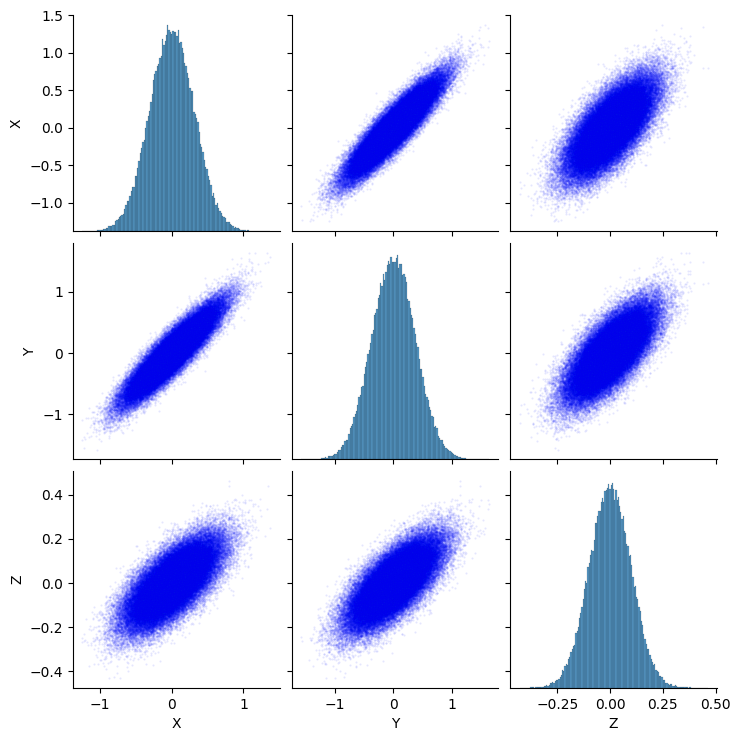

In [71]:
x_pred,y_pred,z_pred=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)()

sns.pairplot(pd.DataFrame({'X':x_pred.detach().numpy(),'Y':y_pred.detach().numpy(),'Z':z_pred.detach().numpy(),}), kind='scatter', markers='.', plot_kws=dict(s=1, edgecolor='b', alpha=0.1, linewidth=1))
plt.show()

In [72]:
Predictive(obs_model, guide=obs_guide, num_samples=2)(X=x_obs,Y=y_obs,Z=z_obs)

{'alpha': tensor([[1.2174],
         [1.2333]]),
 'beta': tensor([[2.1877],
         [2.2693]]),
 'gamma': tensor([[0.3185],
         [0.3229]]),
 'delta': tensor([[-0.2370],
         [-0.2435]]),
 'sigmaZ': tensor([[0.0968],
         [0.0958]]),
 'sigmaH': tensor([[0.4114],
         [0.4443]]),
 'sigmaX': tensor([[0.1856],
         [0.1802]]),
 'sigmaY': tensor([[0.1300],
         [0.1277]]),
 'meanH': tensor([[0.0166],
         [0.0021]]),
 'H': tensor([[-0.1044,  0.4330,  0.1805,  ..., -0.6272,  0.2307, -0.6542],
         [-0.3699,  0.2061, -0.1498,  ..., -0.2059,  0.2239, -0.4251]]),
 'Z': tensor([[-0.0415,  0.0110,  0.1154,  ...,  0.0407,  0.0144, -0.1080],
         [-0.0415,  0.0110,  0.1154,  ...,  0.0407,  0.0144, -0.1080]]),
 'X': tensor([[-0.3195,  0.3035,  0.3117,  ...,  0.0796,  0.3246, -0.5417],
         [-0.3195,  0.3035,  0.3117,  ...,  0.0796,  0.3246, -0.5417]]),
 'Y': tensor([[-0.0536,  0.2772,  0.3293,  ...,  0.2076,  0.3197, -0.3697],
         [-0.0536,  0.2772,  0.

In [73]:
# x_pred,y_pred,z_pred=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)()


Shapes Y: torch.Size([1, 1, 1, 200, 100000]), torch.Size([1, 1, 1, 200, 100000])
ate_direct=1.2322041988372803
Shapes Y: torch.Size([1, 1, 1, 200, 100000]), torch.Size([1, 1, 1, 200, 100000]), X: torch.Size([1, 1, 1, 200, 100000]), torch.Size([1, 1, 1, 200, 100000])
xz = 2.226802349090576, yz = 2.7451908588409424, ate_2sls = 1.232795000076294


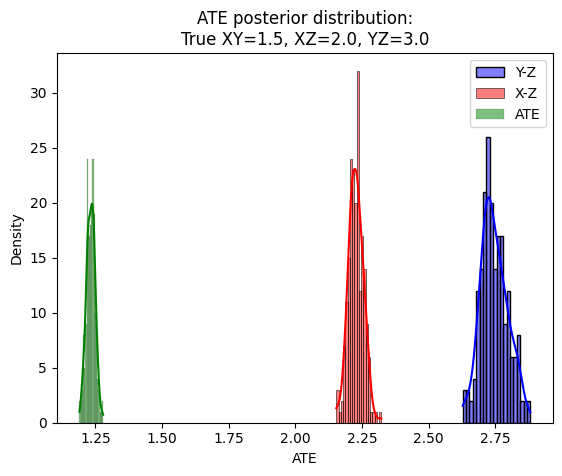

In [74]:
num_mc_samples = 200
with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    # x_all,y_all = PredictiveModel(ObservedBayesianLinearGaussianSCM(),obs_guide)(x_obs,y_obs,z_obs)
    x_all,y_all,_=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)()

    y_cf_1 = gather(y_all, IndexSet(X={2}))
    y_cf_0 = gather(y_all, IndexSet(X={1}))
    ate = (y_cf_1 - y_cf_0).mean()
    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}')
    print(f'ate_direct={ate}')

# now the two-stage approach
with MultiWorldCounterfactual(), do(actions=dict(Z=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    x_all,y_all,_=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)()
    y_cf_1 = gather(y_all, IndexSet(Z={2}))
    y_cf_0 = gather(y_all, IndexSet(Z={1}))

    x_cf_1 = gather(x_all, IndexSet(Z={2}))
    x_cf_0 = gather(x_all, IndexSet(Z={1}))

    xz = (x_cf_1 - x_cf_0).mean()
    yz = (y_cf_1 - y_cf_0).mean()

    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}, X: {x_cf_1.shape}, {x_cf_0.shape}')

    ate = yz / xz
    print(f'xz = {xz}, yz = {yz}, ate_2sls = {ate}')

# plot the distributions
sns.histplot((y_cf_1-y_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='blue', label='Y-Z')
sns.histplot((x_cf_1-x_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='red', label='X-Z')
sns.histplot(((y_cf_1-y_cf_0).mean(dim=-1)/(x_cf_1-x_cf_0).mean(dim=-1)).squeeze().detach().numpy(), bins=20, kde=True, color='green', label='ATE')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution:\nTrue XY={true_alpha}, XZ={true_beta}, YZ={true_alpha*true_beta}')
plt.legend()
plt.show()

Shapes Y: torch.Size([1, 1, 1, 2000, 1000]), torch.Size([1, 1, 1, 2000, 1000])
ate_direct=1.4999024868011475
Shapes Y: torch.Size([1, 1, 1, 2000, 1000]), torch.Size([1, 1, 1, 2000, 1000]), X: torch.Size([1, 1, 1, 2000, 1000]), torch.Size([1, 1, 1, 2000, 1000])
xz = 2.000030517578125, yz = 3.00001859664917, ate_2sls = 1.4999864101409912


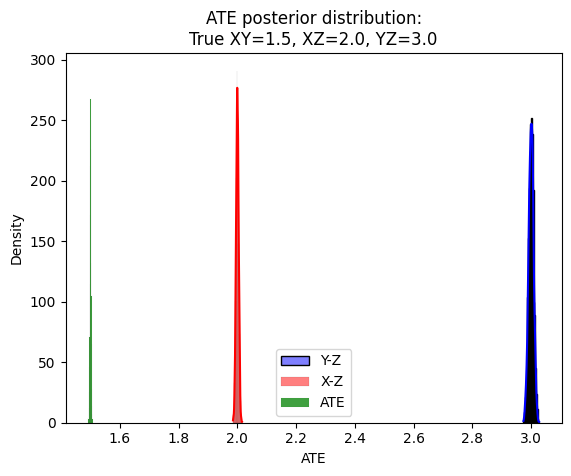

In [55]:
num_mc_samples = 2000
with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2), pyro.plate('samples', 1000, dim=-1):
    # x_all,y_all = PredictiveModel(ObservedBayesianLinearGaussianSCM(),obs_guide)(x_obs,y_obs,z_obs)
    x_all,y_all,_=gt_model()

    y_cf_1 = gather(y_all, IndexSet(X={2}))
    y_cf_0 = gather(y_all, IndexSet(X={1}))
    ate = (y_cf_1 - y_cf_0).mean()
    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}')
    print(f'ate_direct={ate}')

# now the two-stage approach
with MultiWorldCounterfactual(), do(actions=dict(Z=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2), pyro.plate('samples', 1000, dim=-1):
    x_all,y_all,_=gt_model()
    y_cf_1 = gather(y_all, IndexSet(Z={2}))
    y_cf_0 = gather(y_all, IndexSet(Z={1}))

    x_cf_1 = gather(x_all, IndexSet(Z={2}))
    x_cf_0 = gather(x_all, IndexSet(Z={1}))

    xz = (x_cf_1 - x_cf_0).mean()
    yz = (y_cf_1 - y_cf_0).mean()

    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}, X: {x_cf_1.shape}, {x_cf_0.shape}')

    ate = yz / xz
    print(f'xz = {xz}, yz = {yz}, ate_2sls = {ate}')

# plot the distributions
sns.histplot((y_cf_1-y_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='blue', label='Y-Z')
sns.histplot((x_cf_1-x_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='red', label='X-Z')
sns.histplot(((y_cf_1-y_cf_0).mean(dim=-1)/(x_cf_1-x_cf_0).mean(dim=-1)).squeeze().detach().numpy(), bins=20, kde=False, color='green', label='ATE')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution:\nTrue XY={true_alpha}, XZ={true_beta}, YZ={true_alpha*true_beta}')
plt.legend()
# plt.xlim(-3,3)
plt.show()

In [45]:
Predictive(obs_model, guide=obs_guide, num_samples=2)(X=x_obs,Y=y_obs,Z=z_obs)

{'alpha': tensor([[-1.5370],
         [-1.5234]]),
 'beta': tensor([[3.3918],
         [3.2530]]),
 'gamma': tensor([[1.4341],
         [1.4084]]),
 'delta': tensor([[-4.4012],
         [-4.3310]]),
 'sigmaZ': tensor([[1.0003],
         [0.9834]]),
 'sigmaH': tensor([[1.8226],
         [1.8397]]),
 'sigmaX': tensor([[1.6989],
         [1.7221]]),
 'sigmaY': tensor([[1.5430],
         [1.5976]]),
 'meanH': tensor([[0.0281],
         [0.0017]]),
 'H': tensor([[-2.5071, -3.1506,  0.9421,  ...,  0.4166, -4.1101,  3.8694],
         [-2.6276, -2.5514,  0.6613,  ...,  0.2577, -4.6168,  4.0735]]),
 'Z': tensor([[ 0.7885, -0.3294,  0.0822,  ...,  1.3503,  0.4313,  0.3643],
         [ 0.7885, -0.3294,  0.0822,  ...,  1.3503,  0.4313,  0.3643]]),
 'X': tensor([[-2.0925, -3.8881,  1.2720,  ...,  9.8046, -4.1794,  8.3592],
         [-2.0925, -3.8881,  1.2720,  ...,  9.8046, -4.1794,  8.3592]]),
 'Y': tensor([[ 15.1246,  18.8298,  -5.9098,  ..., -17.2159,  22.6230, -30.7515],
         [ 15.1246,  18

Shapes Y: torch.Size([1, 1, 1, 200, 100000]), torch.Size([1, 1, 1, 200, 100000])
ate_direct=0.4788550138473511
Shapes Y: torch.Size([1, 1, 1, 200, 100000]), torch.Size([1, 1, 1, 200, 100000]), X: torch.Size([1, 1, 1, 200, 100000]), torch.Size([1, 1, 1, 200, 100000])
xz = 2.455693244934082, yz = 1.179182767868042, ate_2sls = 0.4801832437515259


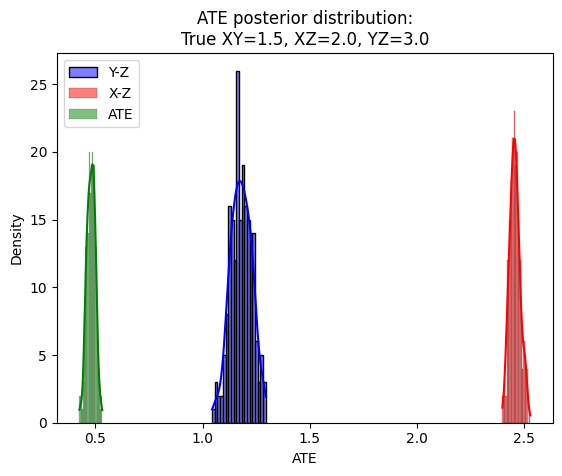

In [56]:
num_mc_samples = 200
with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    # x_all,y_all = PredictiveModel(ObservedBayesianLinearGaussianSCM(),obs_guide)(x_obs,y_obs,z_obs)
    x_all,y_all,_=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), pyro.poutine.block(hide=['H'])(obs_guide))()

    y_cf_1 = gather(y_all, IndexSet(X={2}))
    y_cf_0 = gather(y_all, IndexSet(X={1}))
    ate = (y_cf_1 - y_cf_0).mean()
    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}')
    print(f'ate_direct={ate}')

# now the two-stage approach
with MultiWorldCounterfactual(), do(actions=dict(Z=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    x_all,y_all,_=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), pyro.poutine.block(hide=['H'])(obs_guide))()
    y_cf_1 = gather(y_all, IndexSet(Z={2}))
    y_cf_0 = gather(y_all, IndexSet(Z={1}))

    x_cf_1 = gather(x_all, IndexSet(Z={2}))
    x_cf_0 = gather(x_all, IndexSet(Z={1}))

    xz = (x_cf_1 - x_cf_0).mean()
    yz = (y_cf_1 - y_cf_0).mean()

    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}, X: {x_cf_1.shape}, {x_cf_0.shape}')

    ate = yz / xz
    print(f'xz = {xz}, yz = {yz}, ate_2sls = {ate}')

# plot the distributions
sns.histplot((y_cf_1-y_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='blue', label='Y-Z')
sns.histplot((x_cf_1-x_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='red', label='X-Z')
sns.histplot(((y_cf_1-y_cf_0).mean(dim=-1)/(x_cf_1-x_cf_0).mean(dim=-1)).squeeze().detach().numpy(), bins=20, kde=True, color='green', label='ATE')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution:\nTrue XY={true_alpha}, XZ={true_beta}, YZ={true_alpha*true_beta}')
plt.legend()
plt.show()